In [81]:
import numpy as np
import pandas as pd
import pickle
# SQL related packages
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
# sklearn packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.linear_model import LogisticRegression as Log
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics.scorer import make_scorer
# text analysis packages
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim.models import word2vec, Word2Vec

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Load non-text features

In [2]:
# read the data with the non-text features
patents = pd.read_pickle("patent_data/nontext_features.p")

In [3]:
# check the data
print patents.shape
patents.head()

(12030, 16)


,id,publication_year,B,C,D,E,F,G,H,num_applications,num_patent_citations,num_nonpatent_citations,num_claims,num_similar_doc,num_authors,payment_times
0,US6699658B1,2004,0,1,0,0,0,0,0,5,28,34,42,1,4,3
1,US6699724B1,2004,0,0,0,0,0,1,0,32,47,44,25,0,4,3
2,US6690816B2,2004,0,0,0,0,0,1,0,8,9,0,32,1,4,1
3,US6711436B1,2004,0,0,0,0,0,0,0,4,105,109,45,7,1,3
4,US6711432B1,2004,0,0,0,0,0,0,0,7,15,114,44,3,4,3


#### Format the data

In [4]:
# reformat the response variable into binary
y_data = np.zeros(patents.shape[0])
y_data[patents['payment_times'].values >= 2] = 1

print "Percentage of patents with > 1 maintenance fee payments: ", np.mean(y_data)

Percentage of patents with > 1 maintenance fee payments:  0.62859517872


In [5]:
# prepare the non-text predictors
x_data = patents.drop(['id', 'payment_times', 'publication_year'], axis = 1).values
x_data.shape

(12030, 13)

### Load claims data

In [6]:
# access to sql database
dbname = 'patent_db'
username = 'jy'
pswd = 'jy'

engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))

# reading from sql database
# connect:
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

In [7]:
# read data from 2004-2007
years = np.arange(2004, 2008)

# dataframe to store the results
claims = pd.DataFrame()

# import the abstract from each table
for year in years:
    # query:
    sql_query = """
    SELECT claims, id, payment_times, classification
        FROM patents_%s;
    """ %str(year)

    results = pd.read_sql_query(sql_query,con)
    
    claims = pd.concat([claims, results], axis = 0)
    
# check size of the data
claims.shape

(12033, 4)

In [8]:
# remove the patents missing classification data
missing_class_index = (claims['classification'].values == 'NA')

# reassign patent index
claims.index = range(len(claims.index))
# drop the rows
claims =  claims.drop(patents.index[missing_class_index])
claims.shape

(12030, 4)

In [9]:
### Function to tokenize and clean a piece of text
# input: a string of text
# output: list of tokens (cleaned words) extracted from the text 
# the function lowercases all words, eliminates English stop words, 
# turns words into lemma and remove tokens with any number in it
def tokenize_cleaning(text):
    # tokenize the text first
    tokens = word_tokenize(text.decode('utf-8'))
    
    # lowercase all the words
    tokens = [w.lower() for w in tokens]
    
    # clean up stop words and punctuations 
    stop_list = stopwords.words('english') + list(string.punctuation)

    tokens_no_stop = [token for token in tokens
                        if token not in stop_list]            

    # use lemma
    # reason: remove the influence of plural or tense
    # but retain the subtle difference in legal writting
    lemmatizer = WordNetLemmatizer()
    tokens_lemma = [lemmatizer.lemmatize(token) for token in tokens_no_stop]
    
    # remove numbers (the actual values are not useful)
    tokens_no_num = []
    for token in tokens_lemma:
        try:
            float(token)
        except:
            tokens_no_num.append(token)
    
    return tokens_no_num

In [10]:
# tokenize_clean the claims and count the occurence of the words

cleaned_text = []
for i in range(claims.shape[0]):
    tokens = tokenize_cleaning(claims['claims'].iloc[i])
    cleaned_text.append(tokens)

In [11]:
# load the trained word2vec model
word2vec_model = Word2Vec.load('models/word2vec_claims_final')

In [12]:
### Function to compute average word-vector for a text
# input: word2vec model and a string of text
# ouput: one vector
# the function compute word2vec vector on each word
# and return the average vector for the text
def dec_vec(model, text):
    # store the vectors for all the words
    vectors = []
    
    # compute on each word
    for j in range(len(text)):
        try:
            vectors.append(model.wv[text[j]])
        except:
            continue
    # zero if the claim is missing
    if not vectors:
        vectors_mean = np.zeros((1, 100))
    # otherwise compute the mean vector
    else:
        vectors_mean = np.nanmean(vectors, axis = 0)
        vectors_mean = vectors_mean.reshape((1, 100))
    
    # return vector mean
    return vectors_mean

In [14]:
# compute average vector for each patent
# initialize by a zero vector
claims_vec = np.zeros((1, 100))

for i in range(claims.shape[0]):
    vec = dec_vec(model, cleaned_text[i])
    claims_vec = np.concatenate([claims_vec, vec], axis = 0)

# remove the initialized vector
claims_vec = claims_vec[1:, :]
# check the data dimension
claims_vec.shape

(12030, 100)

### Combine text and non-text features

In [15]:
# combine the claims data with the non-text features
x_data = np.concatenate([x_data, claims_vec], axis = 1)

In [16]:
# split train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                    test_size = 2000, 
                                                    random_state = 123)

print "Dataset dimensions:"
print "x_train: ", x_train.shape
print "x_test: ", x_test.shape
print "y_train: ", y_train.shape
print "y_test: ", y_test.shape

Dataset dimensions:
x_train:  (10030, 113)
x_test:  (2000, 113)
y_train:  (10030,)
y_test:  (2000,)


In [17]:
### subsampling the training data
# sample the same number of'useful' patents as the 'not useful' patents
# size of each class
num_size = np.sum(y_train == 0)

#random shuffle the rows
n = x_train.shape[0]
perm = range(n)
np.random.shuffle(perm)

x_train = x_train[perm]
y_train = y_train[perm]

# separate the two classes
x_useful = x_train[y_train == 1, :]
x_not_useful = x_train[y_train == 0, :]
y_useful = y_train[y_train == 1]
y_not_useful = y_train[y_train == 0]

# sample num_size from the 'useful' class
x_useful = x_useful[:num_size]
y_useful = y_useful[:num_size]

# combine the two classes
x_train_sub = np.concatenate((x_useful, x_not_useful), axis = 0)
y_train_sub = np.concatenate((y_useful, y_not_useful), axis = 0)

# shuffle again
# shuffle the combined data
n2 = x_train_sub.shape[0]
perm2 = range(n2)
np.random.shuffle(perm2)

x_train_sub = x_train_sub[perm2]
y_train_sub = y_train_sub[perm2]

# check the size
print x_train_sub.shape
print y_train_sub.shape

(7506, 113)
(7506,)


In [17]:
# standardize the predictors
scaler = preprocessing.StandardScaler()

x_train_std = scaler.fit_transform(x_train_sub)
x_test_std = scaler.transform(x_test)

In [25]:
# # load the saved scaler if additional analysis is needed on the same model
# scaler = pickle.load(open('models/final_model_scaler.p', 'r'))
# x_train_std = scaler.transform(x_train_sub)
# x_test_std = scaler.transform(x_test)

### Model training
#### Loss function to select models in cross validation

In [19]:
# write my own scoring function
# compute net value of investment based on estimated cost and value
def my_loss_func(y_actual, y_pred):
    
    # set the price of applying for each patent
    patent_cost = 20
    
    # set the value of a useful patent
    useful_value = 30
    
    total_cost = np.sum(y_pred == 1) * patent_cost
    total_value = np.sum((y_actual == 1) & (y_pred == 1)) * useful_value
    
    profit = total_value -  total_cost
    
    return profit

my_scorer = make_scorer(my_loss_func, greater_is_better=True)

#### Functions to compute average metrics on predictions
Instead of looking at the metrics only on the positive class (y = 1), these functions compute weighted average on the two classes.

In [20]:
# function for computing weighted average F1 score for the two classes
def average_f1_score(y_actual, y_pred):
    # for class 1
    f1_1 = metrics.f1_score(y_actual, y_pred)
    # for class 0
    y_actual_flip = np.zeros(len(y_actual))
    y_actual_flip[y_actual == 0] = 1
    y_pred_flip = np.zeros(len(y_pred))
    y_pred_flip[y_pred == 0] = 1
    f1_2 = metrics.f1_score(y_actual_flip, y_pred_flip)
    
    # weigthed average
    f1 = (f1_1 * np.sum(y_actual == 1) + f1_2 * np.sum(y_actual == 0))/len(y_actual)
    return f1

In [21]:
# function for computing weighted average precision for the two classes
def average_precision(y_actual, y_pred):
    # for class 1
    precision_1 = metrics.precision_score(y_actual, y_pred)
    # for class 0
    y_actual_flip = np.zeros(len(y_actual))
    y_actual_flip[y_actual == 0] = 1
    y_pred_flip = np.zeros(len(y_pred))
    y_pred_flip[y_pred == 0] = 1
    precision_2 = metrics.precision_score(y_actual_flip, y_pred_flip)
    
    # weigthed average
    precision = (precision_1 * np.sum(y_actual == 1) + 
          precision_2 * np.sum(y_actual == 0))/len(y_actual)
    return precision

In [30]:
# function for computing weighted average recall for the two classes
def average_recall(y_actual, y_pred):
    # for class 1
    recall_1 = metrics.recall_score(y_actual, y_pred)
    # for class 0
    y_actual_flip = np.zeros(len(y_actual))
    y_actual_flip[y_actual == 0] = 1
    y_pred_flip = np.zeros(len(y_pred))
    y_pred_flip[y_pred == 0] = 1
    recall_2 = metrics.recall_score(y_actual_flip, y_pred_flip)
    
    # weigthed average
    recall = (recall_1 * np.sum(y_actual == 1) + 
          recall_2 * np.sum(y_actual == 0))/len(y_actual)
    return recall

### Random Forest: final model

In [39]:
### tune random forest

model = RandomForestClassifier(n_estimators = 100)

# tune max_features
param_space = np.arange(2, 16, 2)
# tune max_depth
depth_space = np.arange(2, 16, 2)

grid_model = GridSearchCV(model, n_jobs = 4, 
                          param_grid = {'max_features': param_space,
                                        'max_depth': depth_space}, 
                          cv  = 5, scoring = my_scorer)
# fit on the data
grid_model = grid_model.fit(x_train_std, y_train_sub)

In [40]:
# check results
print "Best accuracy:", grid_model.best_score_
print "Best parameter: ", grid_model.best_params_

Best accuracy: -2023.97282174
Best parameter:  {'max_features': 14, 'max_depth': 12}


In [47]:
## load saved final model
# best_rf = pickle.load(open('models/final_model.p', 'r'))

In [48]:
# # check confusion matrix
# best_rf = grid_model.best_estimator_
# best_rf.fit(x_train_std, y_train_sub)

y_pred = best_rf.predict(x_test_std)

# model performance
print "Test accuracy: ", np.mean(y_pred == y_test)
print "Average F1 score: ", average_f1_score(y_pred, y_test)
print "Average Precision: ", average_precision(y_pred, y_test)
print "Average Recall: ", average_recall(y_pred, y_test)
print "Net value: ", my_loss_func(y_test, y_pred)
metrics.confusion_matrix(y_test, y_pred)

Test accuracy:  0.569
Average F1 score:  0.560065410581
Average Precision:  0.574924040162
Average Recall:  0.569
Net value:  1340


array([[426, 289],
       [573, 712]])

#### Check feature importances

In [59]:
# labels of predictors
text_vector = np.asarray(['text_vector']*100)
predictor_labels = np.concatenate([np.asarray(patents.columns[2:15]), text_vector],
                                  axis = 0)

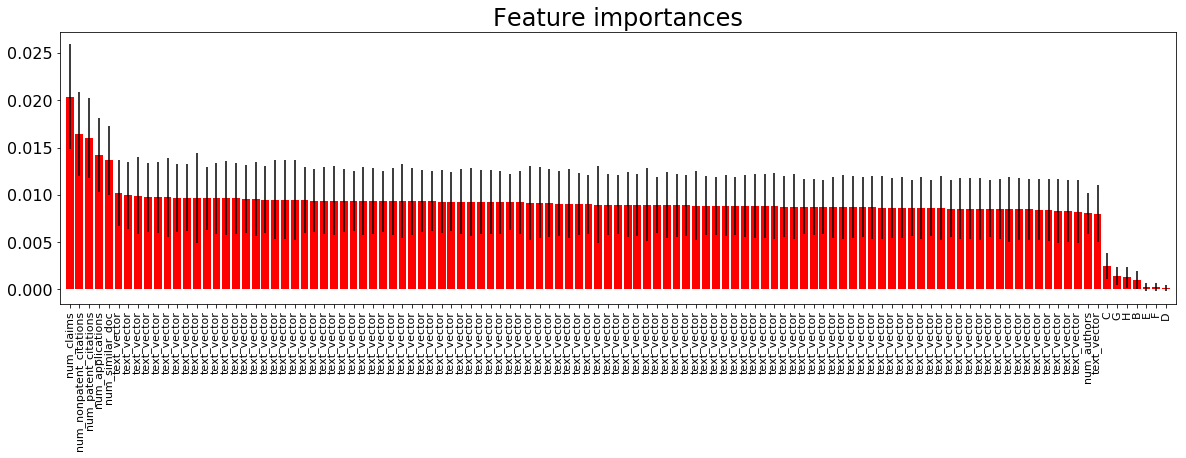

In [83]:
# plot feature importance 
importances = best_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# # Print the feature ranking
# print("Feature ranking:")

# for f in range(x_train_std.shape[1]):
#     print(predictor_labels[indices[f]], importances[indices[f]])

# Plot the feature importances of the RF model
matplotlib.rcParams['font.size'] = 16
plt.figure(figsize = (20, 5))
plt.title("Feature importances", fontsize = 24)
plt.bar(range(x_train_std.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_std.shape[1]), predictor_labels[indices], 
           rotation = 90, fontsize = 11)
plt.xlim([-1, x_train_std.shape[1]])
plt.show()

In [88]:
# contribution of each predictor group
# top non-text features
print "Top non-text features:"
print np.sum(importances[7:12])
# text features
print "Text features:"
print np.sum(importances[13:])
# classification
print "Classification:"
print np.sum(importances[:7])
# the rest
print "Number of authors:"
print importances[12]

Top non-text features:
0.0806787513466
Text features:
0.904430387907
Classification:
0.006834741946
Number of authors:
0.00805611880049


In [87]:
# check the order of non-text predictors
predictor_labels[:20]

array(['B', 'C', 'D', 'E', 'F', 'G', 'H', 'num_applications',
       'num_patent_citations', 'num_nonpatent_citations', 'num_claims',
       'num_similar_doc', 'num_authors', 'text_vector', 'text_vector',
       'text_vector', 'text_vector', 'text_vector', 'text_vector',
       'text_vector'], dtype=object)

### Benchmark

In [44]:
# if everything is predicted to be useful (benchmark)
y_pred_uniform = np.ones(y_pred.shape)
# accuracy
print "Test accuracy: ", np.mean(y_pred_uniform == y_test)
print "Average F1 score: ", average_f1_score(y_test, y_pred_uniform)
print "Average Precision: ", average_precision(y_test, y_pred_uniform)
print "Average Recall: ", average_recall(y_test, y_pred_uniform)
print "Net value: ", my_loss_func(y_test, y_pred_uniform)
metrics.confusion_matrix(y_test, y_pred_uniform)

Test accuracy:  0.6425
Average F1 score:  0.502656012177
Average Precision:  0.41280625
Average Recall:  0.6425
Net value:  -1450


/home/jy/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jy/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[   0,  715],
       [   0, 1285]])

In [43]:
# if randomly assign the two classes with the same ratio
y_pred_random = np.random.uniform(0, 1, size = y_test.shape[0])
# turn into binary
y_random_class = np.zeros(y_test.shape[0]) 
y_random_class[y_pred_random > 1- np.mean(y_test)] = 1

print "Test accuracy: ", np.mean(y_random_class == y_test)
print "Average F1 score: ", average_f1_score(y_test, y_random_class)
print "Average Precision: ", average_precision(y_test, y_random_class)
print "Average Recall: ", average_recall(y_test, y_random_class)
print "Net value: ", my_loss_func(y_test, y_random_class)
metrics.confusion_matrix(y_test, y_random_class)

Test accuracy:  0.547
Average F1 score:  0.546716637733
Average Precision:  0.546437337899
Average Recall:  0.547
Net value:  -760


array([[260, 455],
       [451, 834]])